In [11]:
from typing import List
import numpy as np
import torch
import clip
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from glob import glob
from collections import OrderedDict
from pprint import pprint
import cv2
from collections import Counter
import seaborn as sn
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from time import sleep


In [12]:

class FER_model():
    def __init__(self, text_inputs, weights_name='ViT-B/32') -> None:
        
        self.text_encoded = {}
        
        self.put_name = lambda x, y: x.replace('____', y)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model, self.preprocess = clip.load(weights_name)
        self.model.to(self.device).eval()
        
        
        print('Analyzing inputs...', end='\n')
        
        for detection, inputs in text_inputs.items():
            
            self.text_encoded[detection]={}
            self.text_encoded[detection]['label2labels'] = inputs['labels']
            
            # generate sentences
            self.text_encoded[detection]['sentences'], \
            self.text_encoded[detection]['labels'] = \
                self.generate_sentences(inputs['labels'], 
                                        inputs['templates'])
            
            # encoded senteces to embeding representation
            self.text_encoded[detection]['encoded'] = {}
            self.text_encoded[detection]['encoded']['topk'] = inputs['topk']
            self.text_encoded[detection]['encoded']['sentences'] = {}

            for i, sentences in self.text_encoded[detection]['sentences'].items():
                self.text_encoded[detection]['encoded']['sentences'][i] = self.text_encoder(sentences)

        # Generated sentences:
        for cls, inputs in self.text_encoded.items():
            print(f'{cls}: ')
            for i, tmp in self.text_encoded[cls]['sentences'].items():
                print(f'sentence {i}:')
                for t in tmp:
                    print(f'\t- {t}')
        
    def generate_sentences(self, index2label, templates):
        all_sentences={}
        
        all_labels = [item for _, vals in index2label.items() for item in vals] #list with all labels

        for i, template in enumerate(templates):
            all_sentences[i] = [self.put_name(template, label) for label in  all_labels]
        
        return all_sentences, all_labels


    def text_encoder(self, descriptions):
        text_tokens = clip.tokenize(descriptions).to(self.device)
        with torch.no_grad():
            text_features = self.model.encode_text(text_tokens).float()
            text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features
    
    
    def decision_making(self, outputs):

        tmp_result = {0:[], 1:[], 2:[]}
        for i in range(len(outputs)):
            first, second, third = list(outputs[i].keys())[:3]
            tmp_result[0].append(first)
            tmp_result[1].append(second)
            tmp_result[2].append(third)
        
        final_result = {}

        for i in range(3):
            counter_labels = Counter(tmp_result[i])
            key = next(iter(counter_labels)) # extract the largest value
            apperences = counter_labels[key] # get the number of apperences
            apperences = apperences/sum(counter_labels.values()) # 
            final_result[i] = (key, apperences)
        
        return final_result
        
               
    
    def infer(self, image):
        preprocess_images = []

        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        if isinstance(image, np.ndarray): 
            image = Image.fromarray(image) 

        preprocess_images.append(self.preprocess(image))
        image_input =  torch.tensor(np.stack(preprocess_images)).to(self.device)
        
        with torch.no_grad():
            image_features = self.model.encode_image(image_input).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        final_result = {}
        for cls in self.text_encoded.keys():
            self.text_encoded[cls]['encoded']['results'] = {}
            
            for i, text_features in self.text_encoded[cls]['encoded']['sentences'].items():
                
                text_probs = (100.0 * image_features @ text_features.T) #cosine semilartiy 
                
                result = {}
                for t, v in enumerate(text_probs.cpu().numpy()[0]):
                    decoded_label = self.text_encoded[cls]['labels'][t]
                    for label, labels in self.text_encoded[cls]['label2labels'].items():
                        if decoded_label in labels:
                            try:
                                result[label] += v
                            except:
                                result[label] = v
                sorted_result = sorted(result, key=result.get, reverse=True)
                indexes = sorted_result[:self.text_encoded[cls]['encoded']['topk']]
                
                topk={}
                for j in indexes:
                    topk[j] = result[j]/sum(result.values())
                
                
                self.text_encoded[cls]['encoded']['results'][i] = topk
 
            
            if cls == 'emotions':
                final_result[cls] = self.decision_making(self.text_encoded[cls]['encoded']['results'])
            else:
                final_result[cls] = self.text_encoded[cls]['encoded']['results']
        return final_result


In [42]:

class Metrics():   
    def __init__(self, cls_weights=None):
        self.ground_truth = []       
        self.top1_f1 = []
        self.top3_f1 = []

    def update(self, result, gt):

        self.ground_truth.append(gt)

        first, second, third  = result[:3]
        top1, top3 = 0, 0
        top1_label, top3_label = None, None

        if first == gt:
            top1, top3 = 1, 1
            top1_label, top3_label = gt, gt

        elif top3 == 0:
            if second == gt or third== gt:
                top3 = 1
                top1_label, top3_label =first, gt
    
            else:
                top1_label, top3_label =first, first

        self.top1_f1.append(top1_label)
        self.top3_f1.append(top3_label)



    def get(self):
        result = {
            'ground_truth':np.array(self.ground_truth),
            'top1':{
                'results_array':np.array(self.top1_f1)
            },
            'top3':{
                'results_array':np.array(self.top3_f1)
            }
        }

        return result


In [43]:
def exp_result(model, print_result=False):
    experemnt_result = {}
    # iterate over 7 main categories
    for cls_path in glob(f'total_fer/*'):

        # iterate over images
        cls_list = glob(f'{cls_path}/*')

        folder_name, cls = cls_path.split('/')
        metrics = Metrics()
        for path in cls_list:

            out = model.infer(path)
            
            detections = [out['emotions'][j][0] for j in range(len(out['emotions']))]
            metrics.update(detections, cls)

        experemnt_result[cls] = metrics.get()
    return experemnt_result

In [44]:

def save_confusion_matrix(ground_truth, predictions, name, labels=['neutral', 'fear', 'sad', 'angry', 'happy', 'disgust', 'surprise']):
    
    cm = confusion_matrix(ground_truth, predictions, labels=labels)
    df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.2)
    sn.heatmap(df_cm, annot=True, cmap="BuPu_r", fmt='g')
    plt.title(f'{name}')
    plt.savefig(f'outputs/{name}.png')
    plt.show()


##################################################
1_templates_1_labels_3.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- fright face
	- annoyed face
	- miserable face
	- blank face
	- amazed face
	- disgust face
	- delighted face
gender: 
sentence 0:
	- This is a photo of a male person
	- This is a photo of a female person


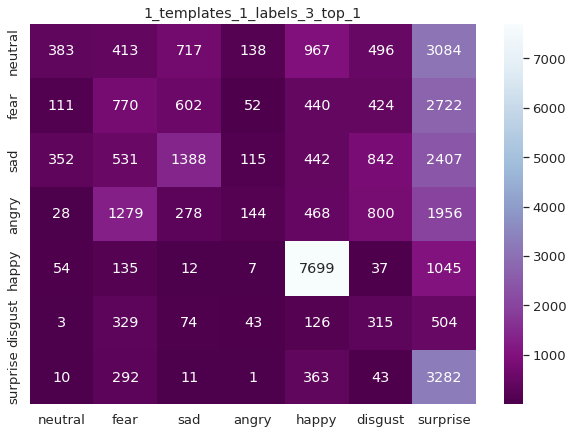

              precision    recall  f1-score
neutral        0.407014  0.061794  0.107298
fear           0.205388  0.150361  0.173619
sad            0.450357  0.228402  0.303090
angry          0.288000  0.029073  0.052815
happy          0.732889  0.856491  0.789884
disgust        0.106527  0.225968  0.144794
surprise       0.218800  0.820090  0.345437
accuracy       0.380601  0.380601  0.380601
macro avg      0.344139  0.338883  0.273848
weighted avg   0.417864  0.380601  0.335987


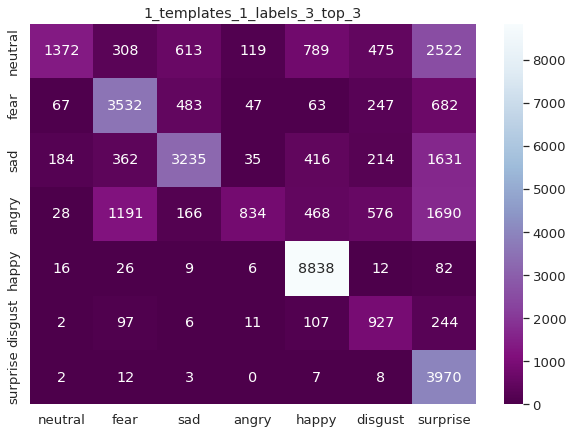

              precision    recall  f1-score
neutral        0.821065  0.221362  0.348710
fear           0.638929  0.689709  0.663349
sad            0.716501  0.532335  0.610838
angry          0.792776  0.168383  0.277769
happy          0.826909  0.983202  0.898308
disgust        0.376983  0.664993  0.481183
surprise       0.366879  0.992004  0.535654
accuracy       0.618174  0.618174  0.618174
macro avg      0.648577  0.607427  0.545116
weighted avg   0.709657  0.618174  0.586256
##################################################

##################################################
3_templates_3_labels_3.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- fearness face
	- fear face
	- nervus face
	- angry face
	- furios face
	- frown face
	- tragic face
	- sad face
	- unfortunate face
	- blank face
	- neutral face
	- expressionless face
	- stunned face
	- amazed face
	- shocked face
	- distaste face
	- disgust face
	- rejected face
	- happy face
	- thrilled face
	- deli

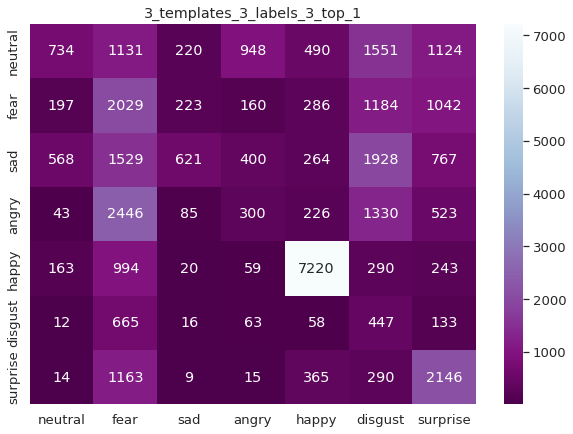

              precision    recall  f1-score
neutral        0.424032  0.118425  0.185143
fear           0.203776  0.396212  0.269134
sad            0.520101  0.102189  0.170816
angry          0.154242  0.060569  0.086982
happy          0.810416  0.803204  0.806794
disgust        0.063675  0.320660  0.106251
surprise       0.358983  0.536232  0.430060
accuracy       0.367425  0.367425  0.367425
macro avg      0.362175  0.333927  0.293597
weighted avg   0.446631  0.367425  0.357056


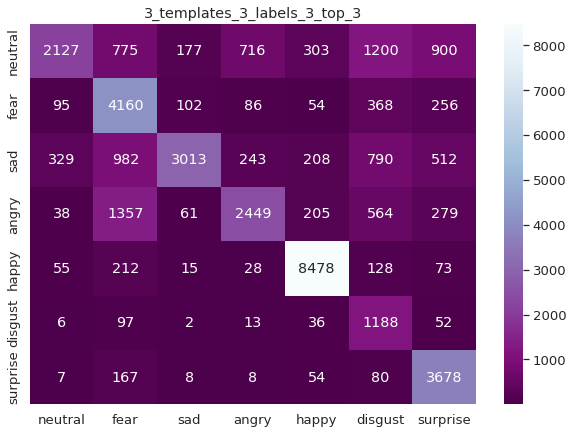

              precision    recall  f1-score
neutral        0.800527  0.343175  0.480407
fear           0.536774  0.812341  0.646414
sad            0.891948  0.495804  0.637335
angry          0.691222  0.494448  0.576507
happy          0.907903  0.943153  0.925192
disgust        0.275127  0.852224  0.415966
surprise       0.639652  0.919040  0.754307
accuracy       0.683100  0.683100  0.683100
macro avg      0.677593  0.694312  0.633733
weighted avg   0.752955  0.683100  0.678704
##################################################

##################################################
2_templates_2_labels_3.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- person with nervus look 
	- person with fear look 
	- person with furios look 
	- person with outraged look 
	- person with sad look 
	- person with pitiful look 
	- person with neutral look 
	- person with non emotinal look 
	- person with stunned look 
	- person with amazed look 
	- person with dislike look 
	- perso

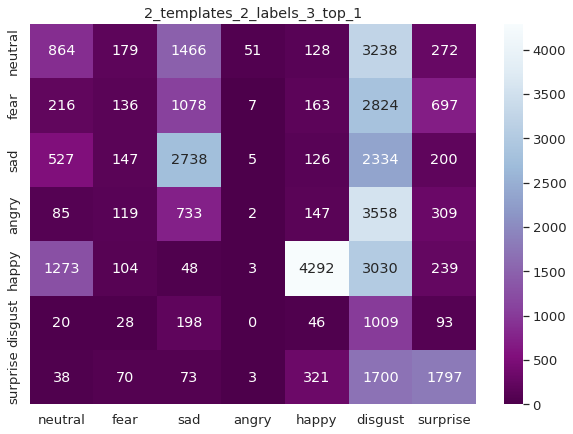

              precision    recall  f1-score
neutral        0.285809  0.139400  0.187398
fear           0.173691  0.026557  0.046070
sad            0.432270  0.450551  0.441221
angry          0.028169  0.000404  0.000796
happy          0.821750  0.477472  0.603997
disgust        0.057028  0.723816  0.105726
surprise       0.498198  0.449025  0.472335
accuracy       0.295040  0.295040  0.295040
macro avg      0.328131  0.323889  0.265364
weighted avg   0.405274  0.295040  0.314413


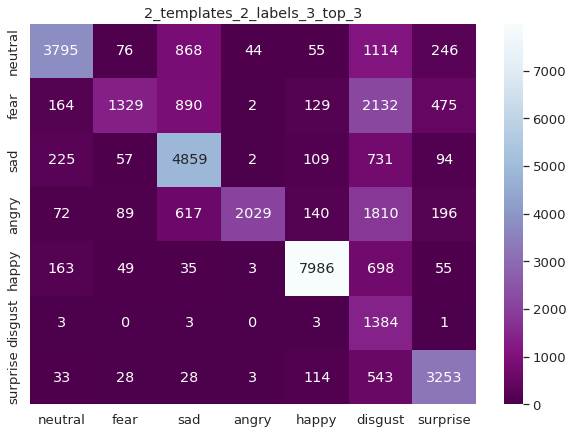

              precision    recall  f1-score
neutral        0.851852  0.612294  0.712475
fear           0.816339  0.259520  0.393836
sad            0.665616  0.799572  0.726471
angry          0.974076  0.409651  0.576748
happy          0.935567  0.888419  0.911384
disgust        0.164527  0.992826  0.282276
surprise       0.753009  0.812844  0.781783
accuracy       0.670632  0.670632  0.670632
macro avg      0.737284  0.682161  0.626425
weighted avg   0.816206  0.670632  0.691969
##################################################

##################################################
2_templates_2_labels_2.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- this is fright person
	- this is fear person
	- this is angered person
	- this is frown person
	- this is pitiful person
	- this is tragic person
	- this is non emotinal person
	- this is neutral person
	- this is stunned person
	- this is astonished person
	- this is disgust person
	- this is dislike person
	- this is

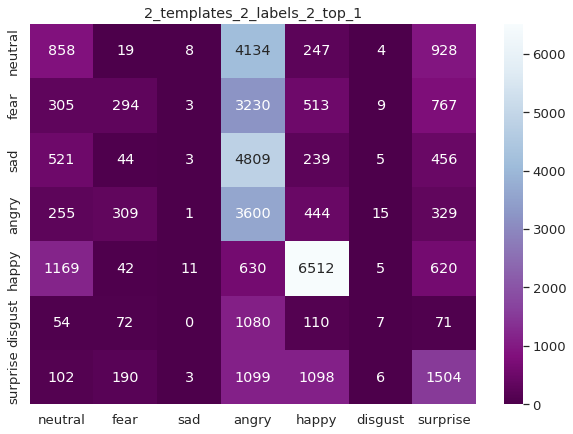

              precision    recall  f1-score
neutral        0.262868  0.138432  0.181357
fear           0.303093  0.057411  0.096536
sad            0.103448  0.000494  0.000983
angry          0.193736  0.726832  0.305927
happy          0.710684  0.724441  0.717497
disgust        0.137255  0.005022  0.009689
surprise       0.321711  0.375812  0.346664
accuracy       0.347852  0.347852  0.347852
macro avg      0.290399  0.289778  0.236950
weighted avg   0.344008  0.347852  0.299180


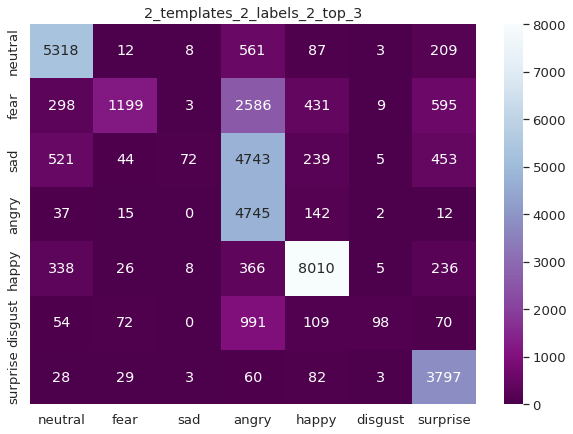

              precision    recall  f1-score
neutral        0.806491  0.858019  0.831457
fear           0.858268  0.234134  0.367904
sad            0.765957  0.011848  0.023335
angry          0.337674  0.958005  0.499342
happy          0.880220  0.891089  0.885621
disgust        0.784000  0.070301  0.129032
surprise       0.706813  0.948776  0.810113
accuracy       0.632629  0.632629  0.632629
macro avg      0.734203  0.567453  0.506686
weighted avg   0.750120  0.632629  0.572637
##################################################

##################################################
2_templates_2_labels_1.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- this is fright person
	- this is fearness person
	- this is outraged person
	- this is angry person
	- this is unfortunate person
	- this is unhappy person
	- this is expressionless person
	- this is non emotinal person
	- this is surprise person
	- this is amazed person
	- this is disgust person
	- this is rejected pe

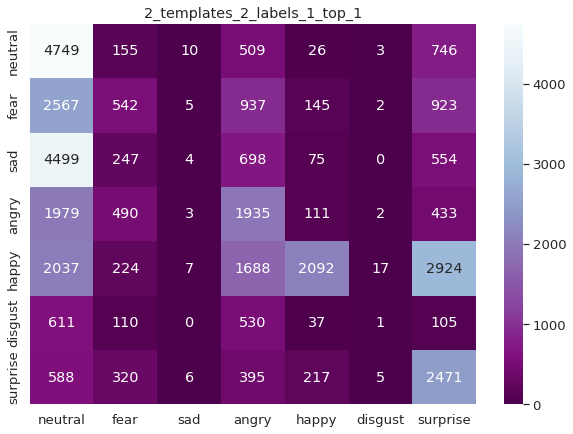

              precision    recall  f1-score
neutral        0.278861  0.766215  0.408903
fear           0.259579  0.105839  0.150368
sad            0.114286  0.000658  0.001309
angry          0.289151  0.390672  0.332331
happy          0.773955  0.232729  0.357852
disgust        0.033333  0.000717  0.001404
surprise       0.302967  0.617441  0.406481
accuracy       0.321065  0.321065  0.321065
macro avg      0.293162  0.302039  0.236950
weighted avg   0.364795  0.321065  0.266887


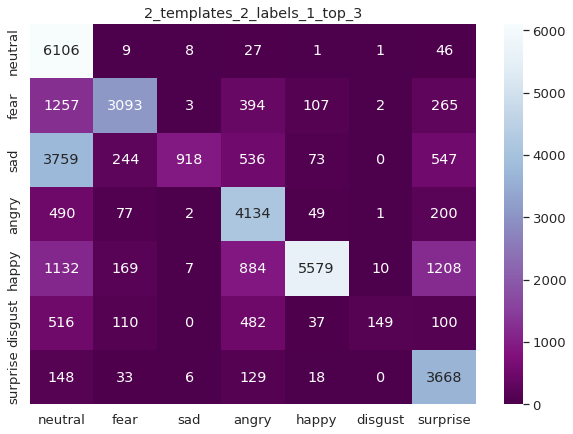

              precision    recall  f1-score
neutral        0.455400  0.985157  0.622871
fear           0.828112  0.603984  0.698509
sad            0.972458  0.151061  0.261501
angry          0.627695  0.834646  0.716527
happy          0.951398  0.620647  0.751229
disgust        0.914110  0.106887  0.191394
surprise       0.607889  0.916542  0.730969
accuracy       0.643736  0.643736  0.643736
macro avg      0.765295  0.602703  0.567571
weighted avg   0.771522  0.643736  0.613074
##################################################

##################################################
1_templates_1_labels_1.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- A photo of a nervus face, a type of expression
	- A photo of a outraged face, a type of expression
	- A photo of a pitiful face, a type of expression
	- A photo of a neutral face, a type of expression
	- A photo of a amazed face, a type of expression
	- A photo of a dislike face, a type of expression
	- A photo of a pl

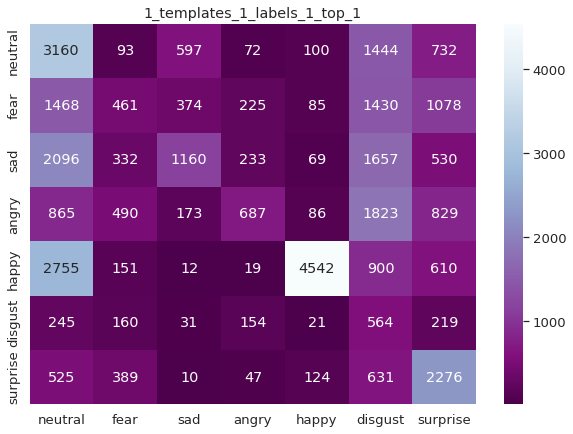

              precision    recall  f1-score
neutral        0.284326  0.509842  0.365065
fear           0.222062  0.090021  0.128109
sad            0.492151  0.190884  0.275077
angry          0.478079  0.138704  0.215023
happy          0.903521  0.505284  0.648116
disgust        0.066753  0.404591  0.114599
surprise       0.362767  0.568716  0.442974
accuracy       0.349812  0.349812  0.349812
macro avg      0.401380  0.344006  0.312709
weighted avg   0.487961  0.349812  0.365161


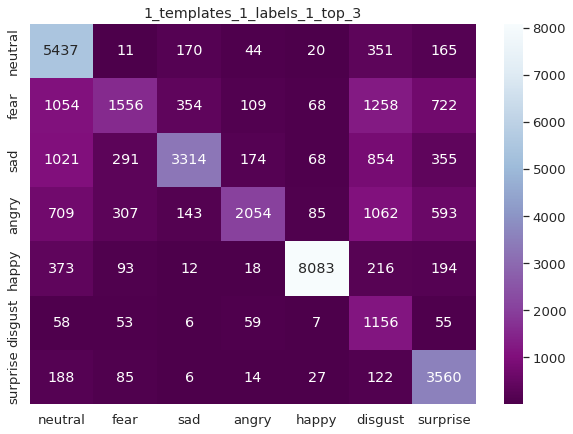

              precision    recall  f1-score
neutral        0.615045  0.877218  0.723101
fear           0.649416  0.303847  0.413995
sad            0.827466  0.545335  0.657409
angry          0.830906  0.414698  0.553266
happy          0.967097  0.899210  0.931919
disgust        0.230325  0.829268  0.360518
surprise       0.630758  0.889555  0.738130
accuracy       0.684924  0.684924  0.684924
macro avg      0.678716  0.679876  0.625477
weighted avg   0.757345  0.684924  0.685219
##################################################

##################################################
3_templates_3_labels_2.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- this is fright person
	- this is fearness person
	- this is scary person
	- this is furios person
	- this is angered person
	- this is outraged person
	- this is unhappy person
	- this is tragic person
	- this is unfortunate person
	- this is expressionless person
	- this is non emotinal person
	- this is normal person

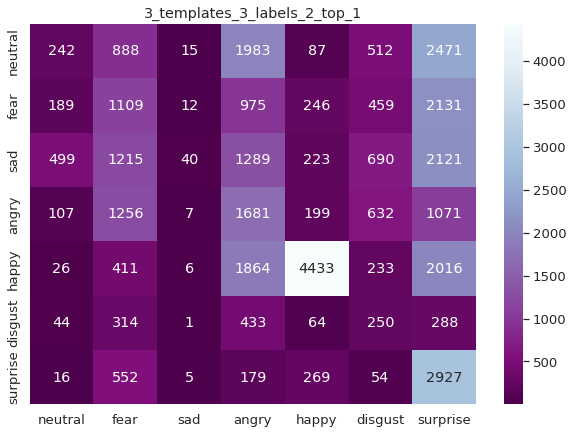

              precision    recall  f1-score
neutral        0.215494  0.039045  0.066111
fear           0.193037  0.216559  0.204123
sad            0.465116  0.006582  0.012981
angry          0.200024  0.339390  0.251703
happy          0.802934  0.493158  0.611027
disgust        0.088339  0.179340  0.118371
surprise       0.224722  0.731384  0.343807
accuracy       0.290793  0.290793  0.290793
macro avg      0.312810  0.286494  0.229732
weighted avg   0.391503  0.290793  0.267166


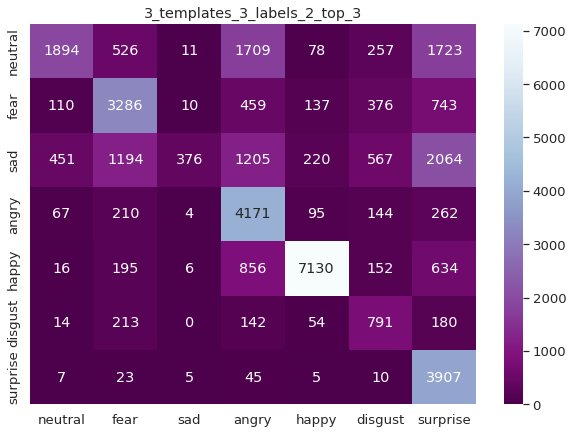

              precision    recall  f1-score
neutral        0.740133  0.305582  0.432568
fear           0.581902  0.641672  0.610327
sad            0.912621  0.061873  0.115888
angry          0.485734  0.842116  0.616100
happy          0.923695  0.793192  0.853483
disgust        0.344362  0.567432  0.428610
surprise       0.410701  0.976262  0.578172
accuracy       0.586786  0.586786  0.586786
macro avg      0.628450  0.598304  0.519307
weighted avg   0.706317  0.586786  0.548419
##################################################

##################################################
1_templates_1_labels_2.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- a photo of a scary looking face.
	- a photo of a angry looking face.
	- a photo of a unfortunate looking face.
	- a photo of a expressionless looking face.
	- a photo of a surprise looking face.
	- a photo of a distaste looking face.
	- a photo of a thrilled looking face.
gender: 
sentence 0:
	- This is a photo of a ma

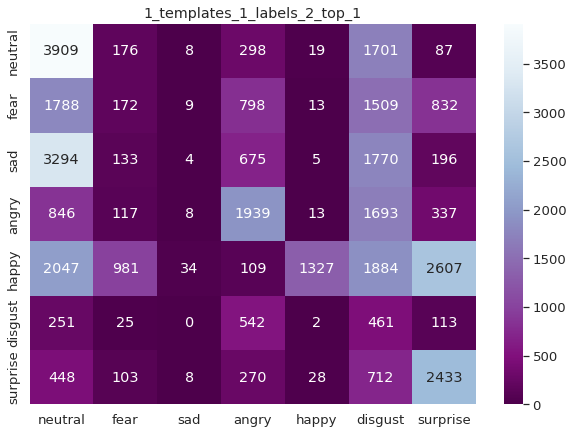

              precision    recall  f1-score
neutral        0.310657  0.630687  0.416272
fear           0.100762  0.033587  0.050381
sad            0.056338  0.000658  0.001301
angry          0.418700  0.391480  0.404633
happy          0.943141  0.147625  0.255290
disgust        0.047379  0.330703  0.082884
surprise       0.368357  0.607946  0.458754
accuracy       0.278897  0.278897  0.278897
macro avg      0.320762  0.306098  0.238502
weighted avg   0.404959  0.278897  0.247628


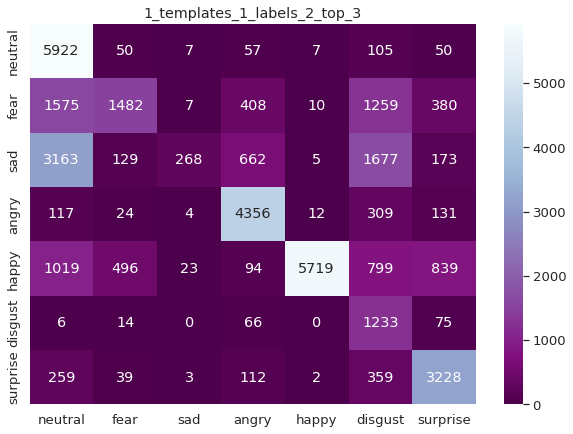

              precision    recall  f1-score
neutral        0.491004  0.955470  0.648666
fear           0.663384  0.289397  0.402991
sad            0.858974  0.044101  0.083894
angry          0.756907  0.879467  0.813597
happy          0.993745  0.636222  0.775773
disgust        0.214771  0.884505  0.345620
surprise       0.662018  0.806597  0.727191
accuracy       0.604563  0.604563  0.604563
macro avg      0.662972  0.642251  0.542533
weighted avg   0.742934  0.604563  0.571382
##################################################

##################################################
3_templates_3_labels_1.pt
____________________
Analyzing inputs...
emotions: 
sentence 0:
	- person with scary look 
	- person with nervus look 
	- person with fearness look 
	- person with annoyed look 
	- person with furios look 
	- person with frown look 
	- person with pitiful look 
	- person with miserable look 
	- person with sad look 
	- person with non emotinal look 
	- person with expressionless look 

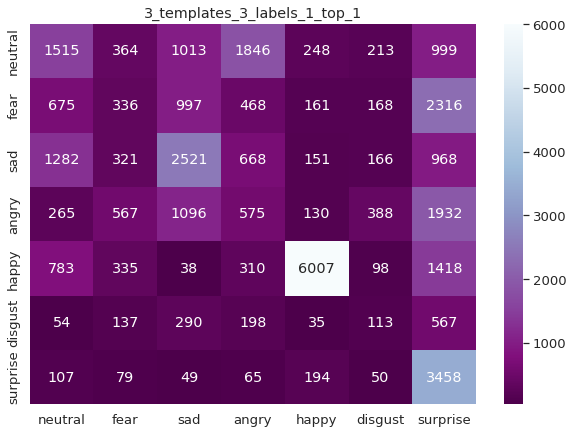

              precision    recall  f1-score
neutral        0.323649  0.244434  0.278518
fear           0.157083  0.065612  0.092562
sad            0.419887  0.414843  0.417350
angry          0.139225  0.116091  0.126610
happy          0.867312  0.668261  0.754885
disgust        0.094482  0.081062  0.087259
surprise       0.296620  0.864068  0.441635
accuracy       0.395410  0.395410  0.395410
macro avg      0.328322  0.350624  0.314117
weighted avg   0.412878  0.395410  0.382162


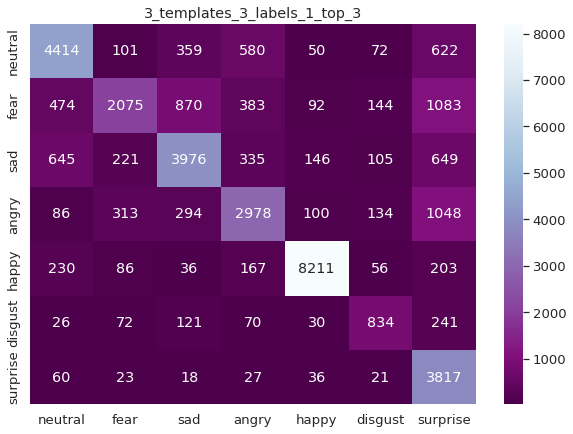

              precision    recall  f1-score
neutral        0.743724  0.712165  0.727602
fear           0.717745  0.405194  0.517973
sad            0.700740  0.654270  0.676708
angry          0.655947  0.601252  0.627410
happy          0.947605  0.913450  0.930214
disgust        0.610542  0.598278  0.604348
surprise       0.498108  0.953773  0.654436
accuracy       0.716094  0.716094  0.716094
macro avg      0.696344  0.691198  0.676956
weighted avg   0.739234  0.716094  0.713381
##################################################


In [20]:

results ={}
for experemnt_result_path in glob('*.pt'):
    print()
    print('#'*50)
    print(experemnt_result_path)
    print('_'*20)
    inputs = torch.load(experemnt_result_path)
    model = FER_model(inputs)
    result = exp_result(model)
    

    labels = result.keys()
    exp_key = experemnt_result_path.split('.')[0]

    ground_truth = []
    predictions1 = []
    predictions3 = []

    for label in labels:
        for gt, res1, res3 in zip(  result[label]['ground_truth'], \
                                    result[label]['top1']['results_array'], \
                                    result[label]['top3']['results_array']):
            ground_truth.append(gt)
            predictions1.append(res1)
            predictions3.append(res3)

        
    report1 = classification_report(ground_truth, 
                                        predictions1, labels=['neutral', 'fear', 'sad', 'angry', 'happy', 'disgust', 'surprise'],
                                        target_names=['neutral', 'fear', 'sad', 'angry', 'happy', 'disgust', 'surprise'],
                                        output_dict=True)

    report1 = pd.DataFrame(report1).iloc[:-1, :].T
    report1.to_csv(f'outputs/{exp_key}_top_1.csv')
    save_confusion_matrix(  ground_truth, 
                            predictions1, 
                            f"{exp_key}_top_1")
    pprint(report1)
    
    
    sleep(1)
    save_confusion_matrix(  ground_truth, 
                            predictions3, 
                            f"{exp_key}_top_3")
   
    report3 = classification_report(ground_truth, 
                                        predictions3, labels=['neutral', 'fear', 'sad', 'angry', 'happy', 'disgust', 'surprise'],
                                        target_names=['neutral', 'fear', 'sad', 'angry', 'happy', 'disgust', 'surprise'],
                                        output_dict=True)
    report3 = pd.DataFrame(report3).iloc[:-1, :].T
    report3.to_csv(f'outputs/{exp_key}_top_3.csv')
    pprint(report3)
    torch.cuda.empty_cache()
    print('#'*50)


In [21]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], y[i], np.round(y[i], decimals=2), ha = 'center', rotation=45, fontsize=14)


# Top 1 result

In [22]:
acc_results = {}
f1_result = {}
# https://towardsdatascience.com/choosing-performance-metrics-61b40819eae1
for i, path in enumerate(glob('outputs/*_top_1.csv')):
    fname = path.rsplit('/', 1)[1].split('.')[0]
    acc_results[fname] = pd.read_csv(path, index_col=0).iloc[7:9].to_dict()['f1-score']['accuracy']
    f1_result[fname] = pd.read_csv(path, index_col=0).iloc[7:9].to_dict()['f1-score']['macro avg']


acc_results = sorted(acc_results.items(), key = lambda kv: kv[1], reverse=True)[:5]
f1_results = sorted(f1_result.items(), key = lambda kv: kv[1], reverse=True)[:5]


In [35]:
def plot_result(results, print_name):
    fig = plt.subplots(figsize =(15, 8))
    barWidth = 0.19

    br1 = np.arange(7)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]
    br6 =[x + barWidth for x in br5]
    br7 =[x + barWidth for x in br6]
    
    brs = [br1, br2, br3, br4, br5, br6, br7]
    index = 0
    colors = ['r', 'b', 'g', 'y', 'c']
    yaccs = []
    xaccs = []
    for acc in results:
        yaccs.append(acc[1])
        xaccs.append(acc[0])
        fname = f'outputs/{acc[0]}'
        csv = pd.read_csv(f'{fname}.csv', index_col=0).iloc[0:7].to_dict()['f1-score']
        labels = list(csv.keys())
        vals = list(csv.values())

        br = brs[index]

        plt.bar(br, vals, color =colors[index], width = barWidth,
            edgecolor ='grey', label =acc[0])

        addlabels(br, vals)

        index+=1


    plt.xticks([r + barWidth for r in np.arange(7)], labels, fontsize=20)

    plt.title(f'classes distribution \nBased on {print_name} results', fontsize=20)
    plt.legend()
    plt.show()   



    plt.barh(xaccs, yaccs, color ='maroon')
    plt.title(f"top 5 options \nBased on {print_name} results", fontsize=20)
    plt.show()




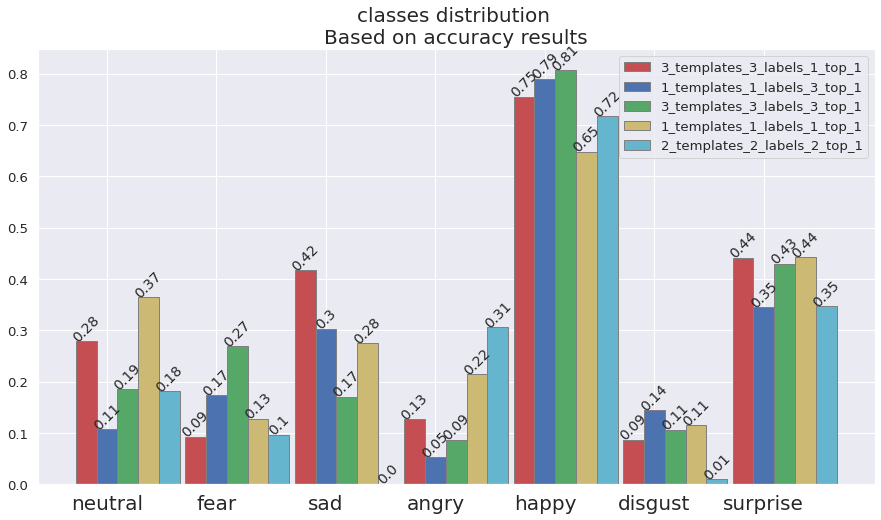

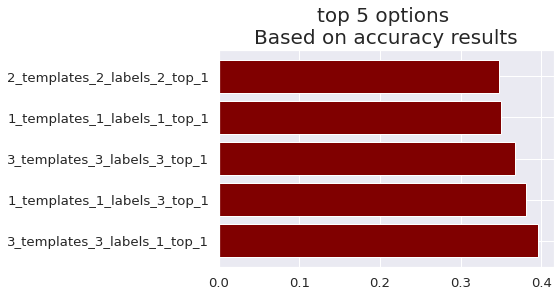

In [36]:
plot_result(acc_results, 'accuracy')


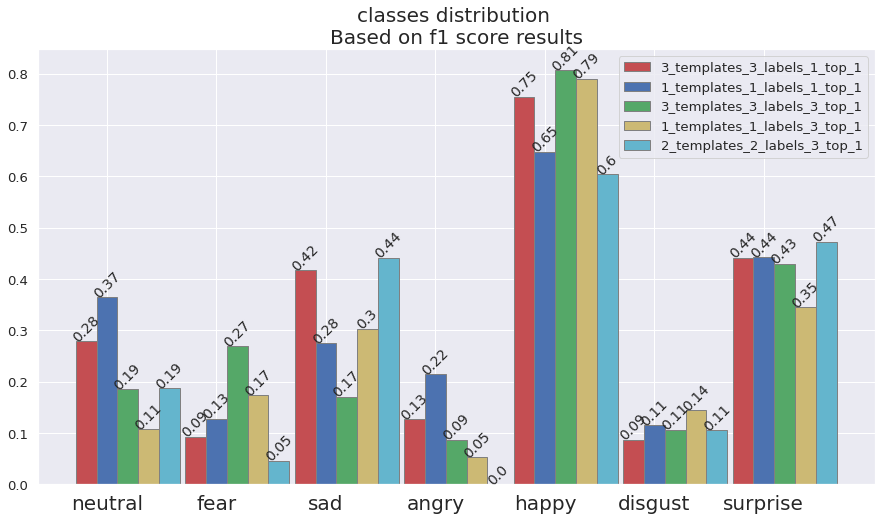

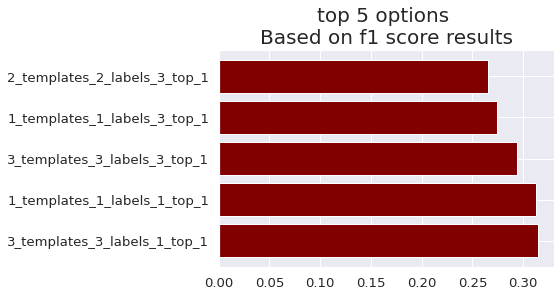

In [37]:
plot_result(f1_results, 'f1 score')

# Top 3 results

In [38]:
acc_results = {}
f1_result = {}
# https://towardsdatascience.com/choosing-performance-metrics-61b40819eae1
for i, path in enumerate(glob('outputs/*_top_3.csv')):
    fname = path.rsplit('/', 1)[1].split('.')[0]
    acc_results[fname] = pd.read_csv(path, index_col=0).iloc[7:9].to_dict()['f1-score']['accuracy']
    f1_result[fname] = pd.read_csv(path, index_col=0).iloc[7:9].to_dict()['f1-score']['macro avg']


acc_results = sorted(acc_results.items(), key = lambda kv: kv[1], reverse=True)[:5]
f1_results = sorted(f1_result.items(), key = lambda kv: kv[1], reverse=True)[:5]


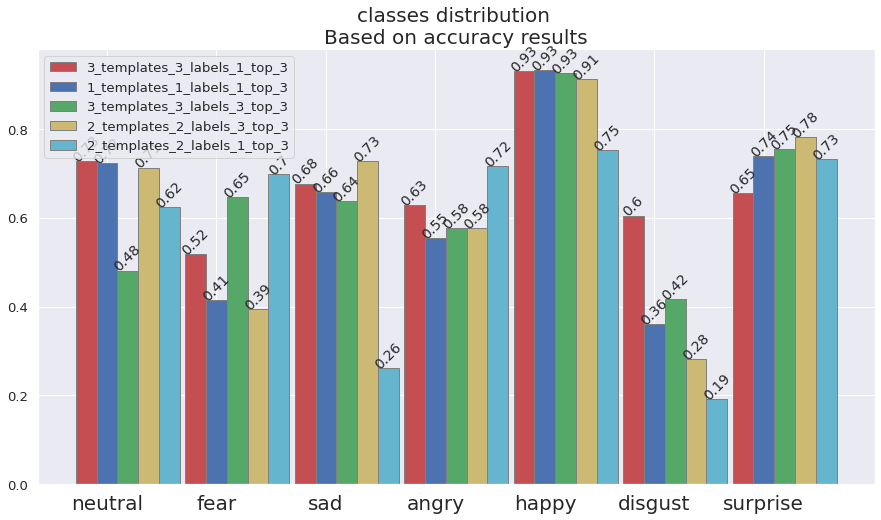

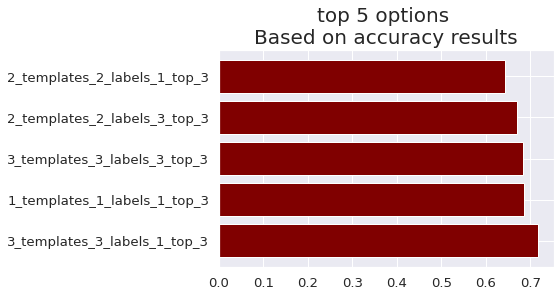

In [39]:
plot_result(acc_results, 'accuracy')


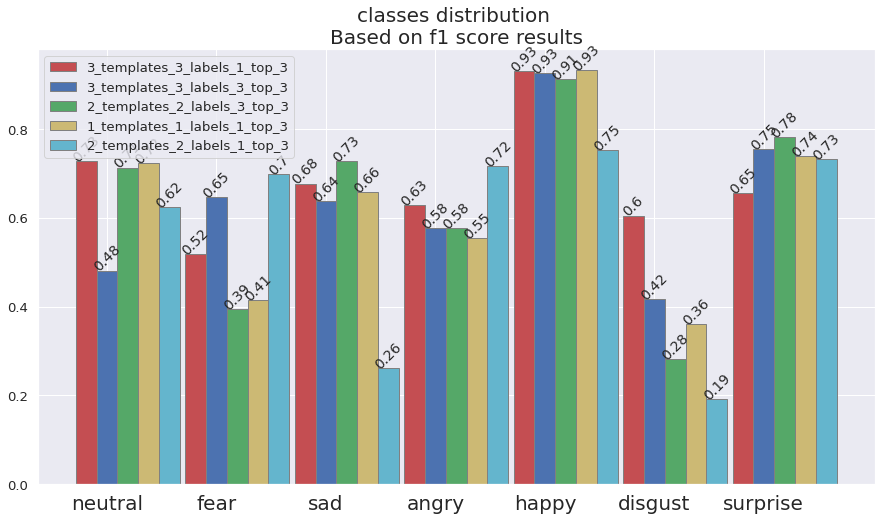

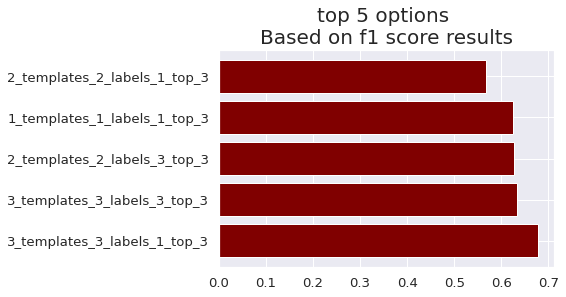

In [40]:
plot_result(f1_results, 'f1 score')